# Config & Import Libraries

In [58]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")

# imports time series
import pandas as pd
import numpy as np

# plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# pip install calmap
#import calmap

# para calculas métricas del modelo
from sklearn.metrics import mean_squared_error

# misc
import os
import datetime
import itertools
import pickle

# apartado ts
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb

# Data Loading

In [4]:
# Leemos los ficheros
ruta = '../data/'
df_forecast = pd.read_csv(ruta+'daily_sales_cleandata.csv')

In [5]:
df_forecast.head()

,id,item,category,department,store,store_code,region,d,qty_sold,date,weekday_int,holiday,weekend,yearweek,sell_price
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,5,0,1,201104,12.7414
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,5,0,1,201104,5.2801
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,5,0,1,201104,3.9501
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,5,0,1,201104,5.7722
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,5,0,1,201104,3.9634


In [6]:
# Pasamos la variable 'date' a tipo fecha:
df_forecast["date"] = pd.to_datetime(df_forecast["date"], format = "%Y-%m-%d")


In [7]:
df_forecast['year'] = df_forecast['yearweek'].astype(str).str[:4]
df_forecast['week'] = df_forecast['yearweek'].astype(str).str[4:] 

In [8]:
df_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Data columns (total 17 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           object        
 1   item         object        
 2   category     object        
 3   department   object        
 4   store        object        
 5   store_code   object        
 6   region       object        
 7   d            object        
 8   qty_sold     int64         
 9   date         datetime64[ns]
 10  weekday_int  int64         
 11  holiday      int64         
 12  weekend      int64         
 13  yearweek     int64         
 14  sell_price   float64       
 15  year         object        
 16  week         object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(10)
memory usage: 7.4+ GB


In [9]:
df_forecast.head()

,id,item,category,department,store,store_code,region,d,qty_sold,date,weekday_int,holiday,weekend,yearweek,sell_price,year,week
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,5,0,1,201104,12.7414,2011,04
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,5,0,1,201104,5.2801,2011,04
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,5,0,1,201104,3.9501,2011,04
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,5,0,1,201104,5.7722,2011,04
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,5,0,1,201104,3.9634,2011,04


In [10]:
# Borramos aquellas variables que no suman al modelo:
df_forecast.drop(['d', 'weekend', 'weekday_int','yearweek'], inplace=True, axis=1)

# Data Transformation: creacion de diccionarios.

In [11]:
store_dict = {

    'South_End': 1,
    'Roxbury': 2,
    'Back_Bay': 3,
    'Greenwich_Village': 4,
    'Harlem' : 5,
    'Tribeca': 6, 
    'Brooklyn': 7,
    'Midtown_Village': 8,
    'Yorktown':9, 
    'Queen_Village': 10

}

df_forecast["store_encode"]=df_forecast["store"].map(store_dict)

In [12]:
department_dict = {

    'SUPERMARKET_3': 1,      
    'HOME_&_GARDEN_1' : 2,   
    'HOME_&_GARDEN_2' :3, 
    'ACCESORIES_1' :4,      
    'SUPERMARKET_2': 5,  
    'SUPERMARKET_1':6,       
    'ACCESORIES_2':7       

}

df_forecast["department_encode"]=df_forecast["department"].map(department_dict)

In [13]:
category_dict = {

    'SUPERMARKET': 1,
    'HOME_&_GARDEN': 2,
    'ACCESORIES': 3
   
}

df_forecast["category_encode"]=df_forecast["category"].map(category_dict)

In [14]:
region_dict ={

    'New York': 1,
    'Boston': 2,
    'Philadelphia':3

}

df_forecast["region_encode"]=df_forecast["region"].map(region_dict)

In [15]:
df_forecast.head(3)

,id,item,category,department,store,store_code,region,qty_sold,date,holiday,sell_price,year,week,store_encode,department_encode,category_encode,region_encode
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,2011-01-29,0,12.7414,2011,04,4,4,3,1
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,2011-01-29,0,5.2801,2011,04,4,4,3,1
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,2011-01-29,0,3.9501,2011,04,4,4,3,1


In [16]:
# Borramos las columnas encodeadas:
df_forecast.drop([
                    'category',
                    'department', 
                    'region', 
                    'store', 
                    'store_code',
                    'item'], 
                    axis=1, inplace=True)

In [17]:
df_forecast.head()

,id,qty_sold,date,holiday,sell_price,year,week,store_encode,department_encode,category_encode,region_encode
0,ACCESORIES_1_001_NYC_1,0,2011-01-29,0,12.7414,2011,04,4,4,3,1
1,ACCESORIES_1_002_NYC_1,0,2011-01-29,0,5.2801,2011,04,4,4,3,1
2,ACCESORIES_1_003_NYC_1,0,2011-01-29,0,3.9501,2011,04,4,4,3,1
3,ACCESORIES_1_004_NYC_1,0,2011-01-29,0,5.7722,2011,04,4,4,3,1
4,ACCESORIES_1_005_NYC_1,0,2011-01-29,0,3.9634,2011,04,4,4,3,1


# Visualizamos las ventas

In [18]:
df = df_forecast.copy()

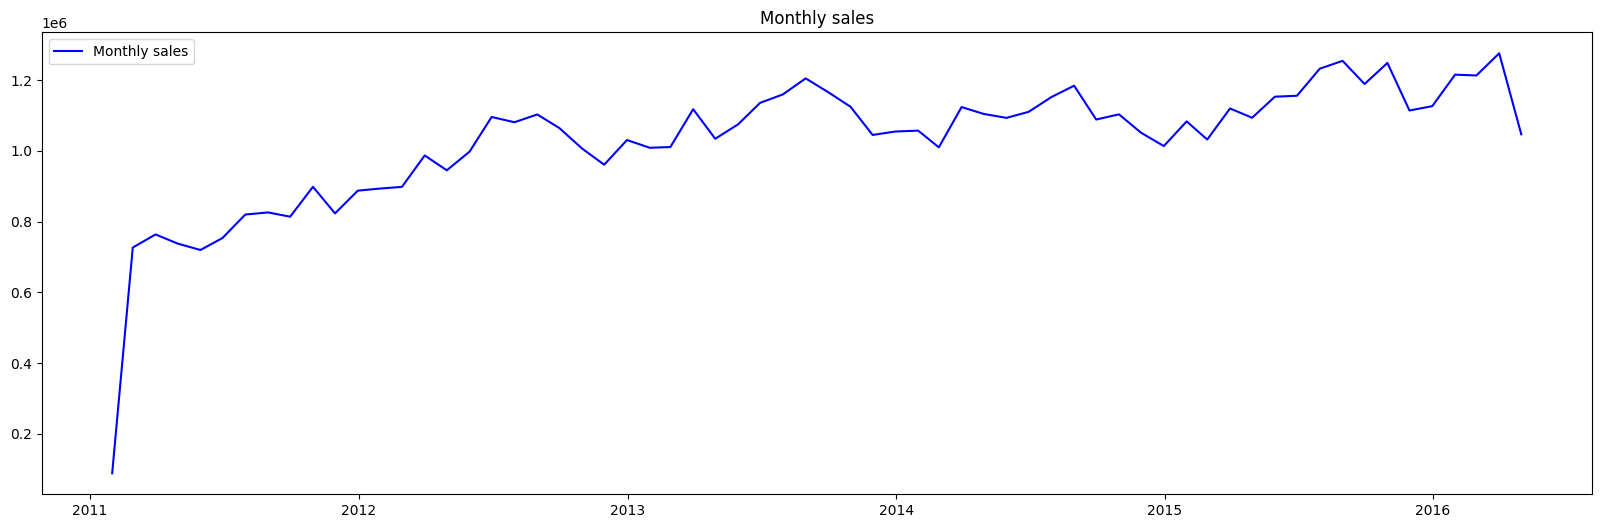

In [19]:
# Consultamos las ventas mensuales:
x= df[['date', "qty_sold"]].set_index('date').resample("M").sum()

# Vemos la evolución de las ventas mensuales:
plt.figure(figsize = (20, 6))
plt.plot(x, color = "blue", label = "Monthly sales")
plt.title("Monthly sales")
plt.legend()

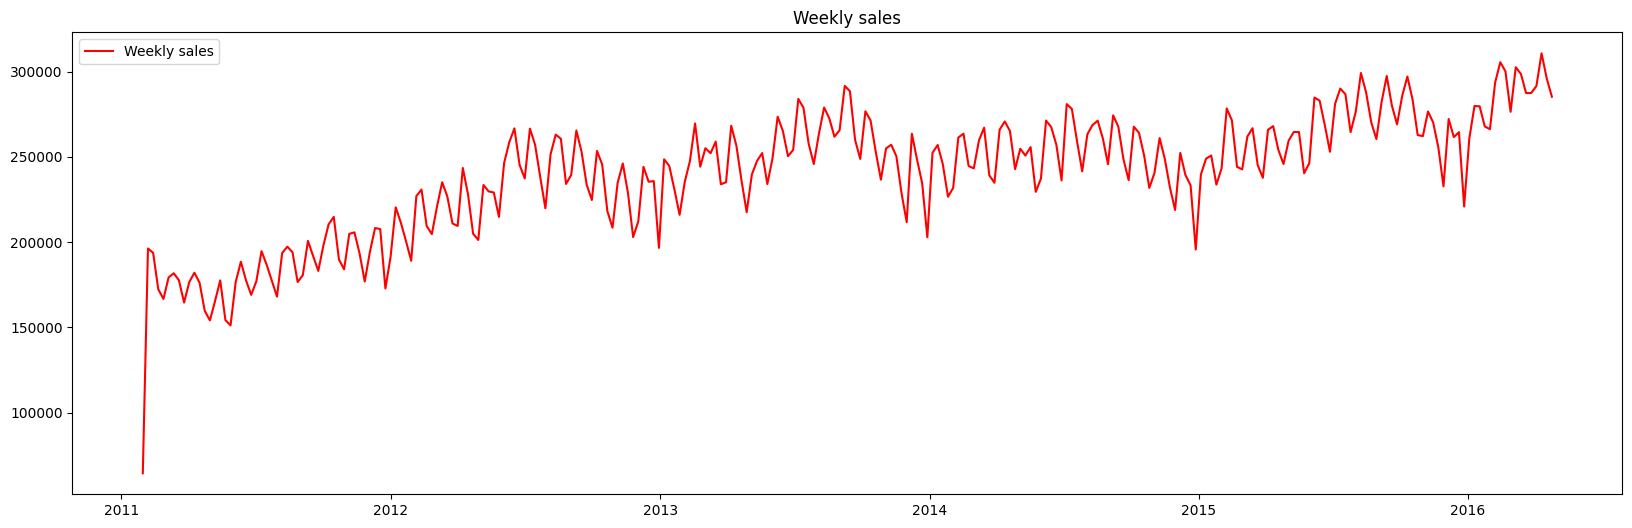

In [20]:
# Consultamos las ventas semanales:
x= df[['date', "qty_sold"]].set_index('date').resample("W").sum()

# Vemos la evolución de las ventas semanales:
plt.figure(figsize = (20, 6))
plt.plot(x, color = "red", label = "Weekly sales")
plt.title("Weekly sales")
plt.legend()

In [23]:
'''import calmap

df_sales_calendar = df[["date", "qty_sold"]]
df_sales_calendar.set_index("date", inplace = True)
df_sales_calendar = df_sales_calendar.resample("D")["qty_sold"].sum()

calmap.calendarplot(df_sales_calendar,
                    fig_kws = {'figsize': (16,10)}, 
                    yearlabel_kws = {'color':'black', 'fontsize':14}, 
                    subplot_kws = {'title':'Total sales per year'})'''

'import calmap\n\ndf_sales_calendar = df[["date", "qty_sold"]]\ndf_sales_calendar.set_index("date", inplace = True)\ndf_sales_calendar = df_sales_calendar.resample("D")["qty_sold"].sum()\n\ncalmap.calendarplot(df_sales_calendar,\n                    fig_kws = {\'figsize\': (16,10)}, \n                    yearlabel_kws = {\'color\':\'black\', \'fontsize\':14}, \n                    subplot_kws = {\'title\':\'Total sales per year\'})'

### EDA: Global Sales

In [33]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2, lags = 14)
    plot_pacf(x = y, ax = ax3, lags = 14)

    plt.suptitle(t = title, fontsize = 20)

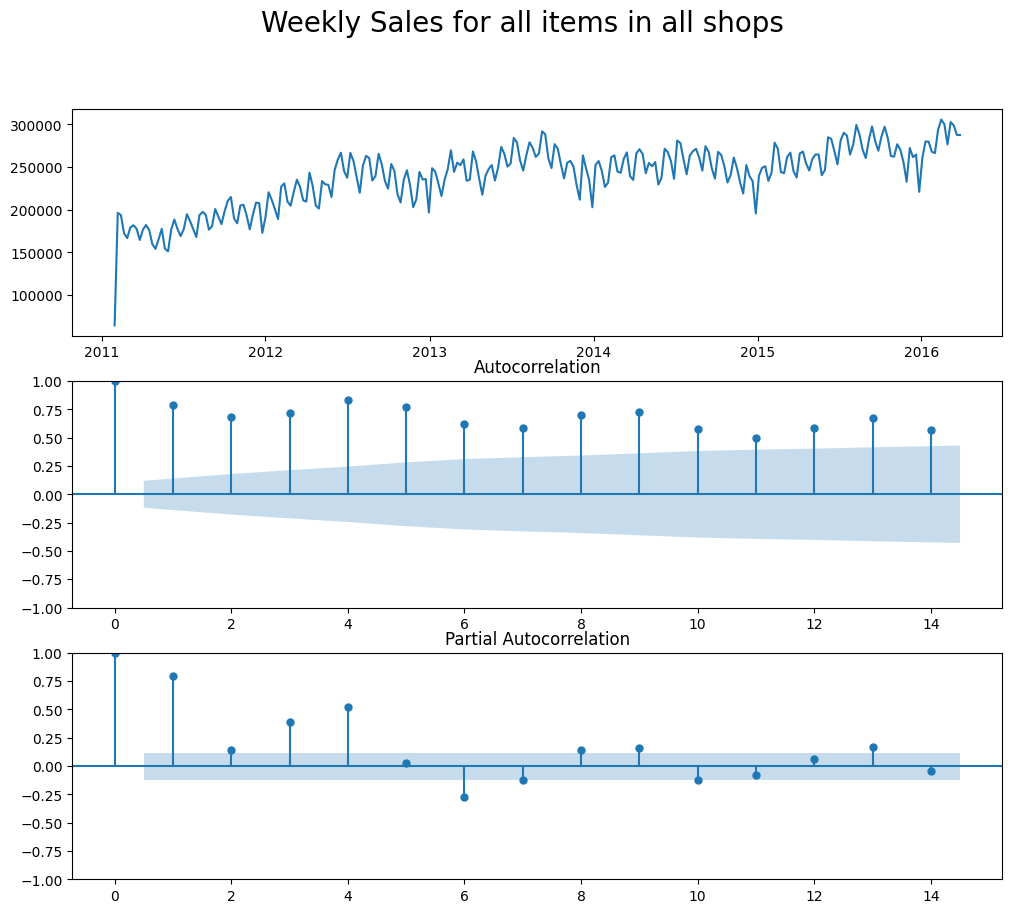

In [34]:
y = df.set_index("date").resample("W")["qty_sold"].sum()[:-4] # quitamos los registros de las ultimas cuatro semanas.
plot_ts_acf_pacf(y = y, title = "Weekly Sales for all items in all shops")

,id,qty_sold,date,holiday,sell_price,year,week,store_encode,department_encode,category_encode,region_encode
0,ACCESORIES_1_001_NYC_1,0,2011-01-29,0,12.7414,2011,04,4,4,3,1
1,ACCESORIES_1_002_NYC_1,0,2011-01-29,0,5.2801,2011,04,4,4,3,1
2,ACCESORIES_1_003_NYC_1,0,2011-01-29,0,3.9501,2011,04,4,4,3,1
3,ACCESORIES_1_004_NYC_1,0,2011-01-29,0,5.7722,2011,04,4,4,3,1
4,ACCESORIES_1_005_NYC_1,0,2011-01-29,0,3.9634,2011,04,4,4,3,1


## · Building Time Series Features:

In [39]:
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name):

    assert "date" in df.columns.tolist(), "Date must be in df columns"

    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample("W")[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )

    gb_df_[f"{new_name}_lag1"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(1)
    )
    gb_df_[f"{new_name}_ma3"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(1).rolling(3).mean()
    )
    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)

    return gb_df_

In [40]:
df.head()

,id,qty_sold,date,holiday,sell_price,year,week,store_encode,department_encode,category_encode,region_encode
0,ACCESORIES_1_001_NYC_1,0,2011-01-29,0,12.7414,2011,04,4,4,3,1
1,ACCESORIES_1_002_NYC_1,0,2011-01-29,0,5.2801,2011,04,4,4,3,1
2,ACCESORIES_1_003_NYC_1,0,2011-01-29,0,3.9501,2011,04,4,4,3,1
3,ACCESORIES_1_004_NYC_1,0,2011-01-29,0,5.7722,2011,04,4,4,3,1
4,ACCESORIES_1_005_NYC_1,0,2011-01-29,0,3.9634,2011,04,4,4,3,1


In [41]:
GB_LIST = ['store_encode','id']          #,"item_id"
TARGET_COLUMN = "qty_sold"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_ = build_ts_vars(
    df = df,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME

)

vars_ts_.head(10)

print(df.shape)
df = pd.merge(df, vars_ts_, on = ["date"] + GB_LIST, how = "left")
print(df.shape)

Dropping columns that might cause target leakage store_encode_id_qty_sold_sum
(58327370, 11)
(58327370, 13)


In [43]:
GB_LIST = ['category_encode','id']          # ,"item_id"
TARGET_COLUMN = "sell_price"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_ = build_ts_vars(
    df = df,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME

)

vars_ts_.head(10)

print(df.shape)
df = pd.merge(df, vars_ts_, on = ["date"] + GB_LIST, how = "left")
print(df.shape)

Dropping columns that might cause target leakage category_encode_id_sell_price_sum
(58327370, 13)
(58327370, 15)


In [44]:
df['sales_mean_rolling'] = df['qty_sold'].transform(lambda series: series.shift(1).rolling(window = 2).mean())

In [45]:
df.head(3)

,id,qty_sold,date,holiday,sell_price,year,week,store_encode,department_encode,category_encode,region_encode,store_encode_id_qty_sold_sum_lag1,store_encode_id_qty_sold_sum_ma3,category_encode_id_sell_price_sum_lag1,category_encode_id_sell_price_sum_ma3,sales_mean_rolling
0,ACCESORIES_1_001_NYC_1,0,2011-01-29,0,12.7414,2011,04,4,4,3,1,NaN,NaN,NaN,NaN,NaN
1,ACCESORIES_1_002_NYC_1,0,2011-01-29,0,5.2801,2011,04,4,4,3,1,NaN,NaN,NaN,NaN,NaN
2,ACCESORIES_1_003_NYC_1,0,2011-01-29,0,3.9501,2011,04,4,4,3,1,NaN,NaN,NaN,NaN,0.0


### Train Test Split

In [46]:
df.columns.tolist()

['id',
 'qty_sold',
 'date',
 'holiday',
 'sell_price',
 'year',
 'week',
 'store_encode',
 'department_encode',
 'category_encode',
 'region_encode',
 'store_encode_id_qty_sold_sum_lag1',
 'store_encode_id_qty_sold_sum_ma3',
 'category_encode_id_sell_price_sum_lag1',
 'category_encode_id_sell_price_sum_ma3',
 'sales_mean_rolling']

In [47]:
COLUMNS_TO_DROP = ['year','week'
]

df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [48]:
df.set_index("id", inplace = True)

In [49]:
df.sample(5)

,qty_sold,date,holiday,sell_price,store_encode,department_encode,category_encode,region_encode,store_encode_id_qty_sold_sum_lag1,store_encode_id_qty_sold_sum_ma3,category_encode_id_sell_price_sum_lag1,category_encode_id_sell_price_sum_ma3,sales_mean_rolling
id,,,,,,,,,,,,,
HOME_&_GARDEN_2_288_BOS_3,1,2013-09-16,0,4.9625,3,3,2,2,NaN,NaN,NaN,NaN,0.0
SUPERMARKET_3_792_BOS_1,3,2013-03-04,0,1.2000,1,1,1,2,NaN,NaN,NaN,NaN,1.0
SUPERMARKET_3_088_NYC_2,0,2011-12-28,0,3.3360,5,1,1,1,NaN,NaN,NaN,NaN,0.0
SUPERMARKET_3_792_NYC_1,0,2011-08-06,0,1.2000,4,1,1,1,NaN,NaN,NaN,NaN,0.0
HOME_&_GARDEN_1_513_BOS_2,0,2012-10-25,0,13.7125,2,2,2,2,NaN,NaN,NaN,NaN,2.0


In [61]:
min_date = df['date'].min()
max_date = df['date'].max()

print('Fecha minima: ', min_date)
print('Fecha maxima: ', max_date)

Fecha minima:  2011-01-29 00:00:00
Fecha maxima:  2016-04-24 00:00:00


In [62]:
train_index = sorted(list(df["date"].unique()))[:-8]

valida_index = [sorted(list(df["date"].unique()))[-8]]

test_index = [sorted(list(df["date"].unique()))[-4]]

In [63]:
print(f"Our train index is {train_index[:2]} - ... - {train_index[-2:]}\n")
print(f"Our validation index is {valida_index}\n")
print(f"Our test/prediction index is {test_index}\n")

Our train index is [Timestamp('2011-01-29 00:00:00'), Timestamp('2011-01-30 00:00:00')] - ... - [Timestamp('2016-04-15 00:00:00'), Timestamp('2016-04-16 00:00:00')]

Our validation index is [Timestamp('2016-04-17 00:00:00')]

Our test/prediction index is [Timestamp('2016-04-21 00:00:00')]



In [64]:
X_train = df[df["date"].isin(train_index)].drop(['qty_sold', "date"], axis=1)
Y_train = df[df["date"].isin(train_index)]['qty_sold']

X_valida = df[df["date"].isin(valida_index)].drop(['qty_sold', "date"], axis=1)
Y_valida = df[df["date"].isin(valida_index)]['qty_sold']

X_test = df[df["date"].isin(test_index)].drop(['qty_sold', "date"], axis = 1)
Y_test = df[df["date"].isin(test_index)]['qty_sold']

In [65]:
X_train.head(3)

,holiday,sell_price,store_encode,department_encode,category_encode,region_encode,store_encode_id_qty_sold_sum_lag1,store_encode_id_qty_sold_sum_ma3,category_encode_id_sell_price_sum_lag1,category_encode_id_sell_price_sum_ma3,sales_mean_rolling
id,,,,,,,,,,,
ACCESORIES_1_001_NYC_1,0,12.7414,4,4,3,1,NaN,NaN,NaN,NaN,NaN
ACCESORIES_1_002_NYC_1,0,5.2801,4,4,3,1,NaN,NaN,NaN,NaN,NaN
ACCESORIES_1_003_NYC_1,0,3.9501,4,4,3,1,NaN,NaN,NaN,NaN,0.0


In [66]:
Y_train.head(3)

id
ACCESORIES_1_001_NYC_1    0
ACCESORIES_1_002_NYC_1    0
ACCESORIES_1_003_NYC_1    0
Name: qty_sold, dtype: int64

# Hiper-parametrizacion

In [67]:
'''from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 75, 100, 150],
    'max_depth': [5, 6, 7],
    'gamma' : [0, 0.1, 0.2],
#    'reg_alpha' : [0, 0.1, 0.01],
#    'reg_lambda': [0.9, 1, 1.1],
    'learning_rate' : [0.1, 0.25, 0.3]
}

grid_search = GridSearchCV(xgb.XGBRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_valida, Y_valida)], verbose = False)

model = grid_search.best_estimator_'''

"from sklearn.model_selection import GridSearchCV\n\nparam_grid = {\n    'n_estimators': [50, 75, 100, 150],\n    'max_depth': [5, 6, 7],\n    'gamma' : [0, 0.1, 0.2],\n#    'reg_alpha' : [0, 0.1, 0.01],\n#    'reg_lambda': [0.9, 1, 1.1],\n    'learning_rate' : [0.1, 0.25, 0.3]\n}\n\ngrid_search = GridSearchCV(xgb.XGBRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error')\ngrid_search.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_valida, Y_valida)], verbose = False)\n\nmodel = grid_search.best_estimator_"

In [68]:
'''print("---- Results from Random Search -----" )
print("\n The best estimator across ALL searched params:", grid_search.best_estimator_)
print("\n The best RMSE:", grid_search.best_score_)
print("\n The best parameters across ALL searched params:\n", grid_search.best_params_)'''

'print("---- Results from Random Search -----" )\nprint("\n The best estimator across ALL searched params:", grid_search.best_estimator_)\nprint("\n The best RMSE:", grid_search.best_score_)\nprint("\n The best parameters across ALL searched params:\n", grid_search.best_params_)'

# Model Train

In [69]:
model = xgb.XGBRegressor(
              eval_metric = "rmse",
              seed = 175
#              , n_estimators = 75
#              , max_depth = 6
#              , gamma = 0
#              , reg_alpha =0
#              , reg_lambda = 1
#              , learning_rate = 0.1
              )

model.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_valida, Y_valida)], verbose = 10)

[0]	validation_0-rmse:3.67064	validation_1-rmse:3.58055
[10]	validation_0-rmse:3.38614	validation_1-rmse:2.35205
[20]	validation_0-rmse:3.35887	validation_1-rmse:2.34257
[30]	validation_0-rmse:3.34792	validation_1-rmse:2.34110
[40]	validation_0-rmse:3.33963	validation_1-rmse:2.34042
[50]	validation_0-rmse:3.33334	validation_1-rmse:2.33837
[60]	validation_0-rmse:3.32893	validation_1-rmse:2.32936
[70]	validation_0-rmse:3.32656	validation_1-rmse:2.32710
[80]	validation_0-rmse:3.32361	validation_1-rmse:2.32589
[90]	validation_0-rmse:3.32133	validation_1-rmse:2.32432
[99]	validation_0-rmse:3.31956	validation_1-rmse:2.32514


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### >> Model Evaluation

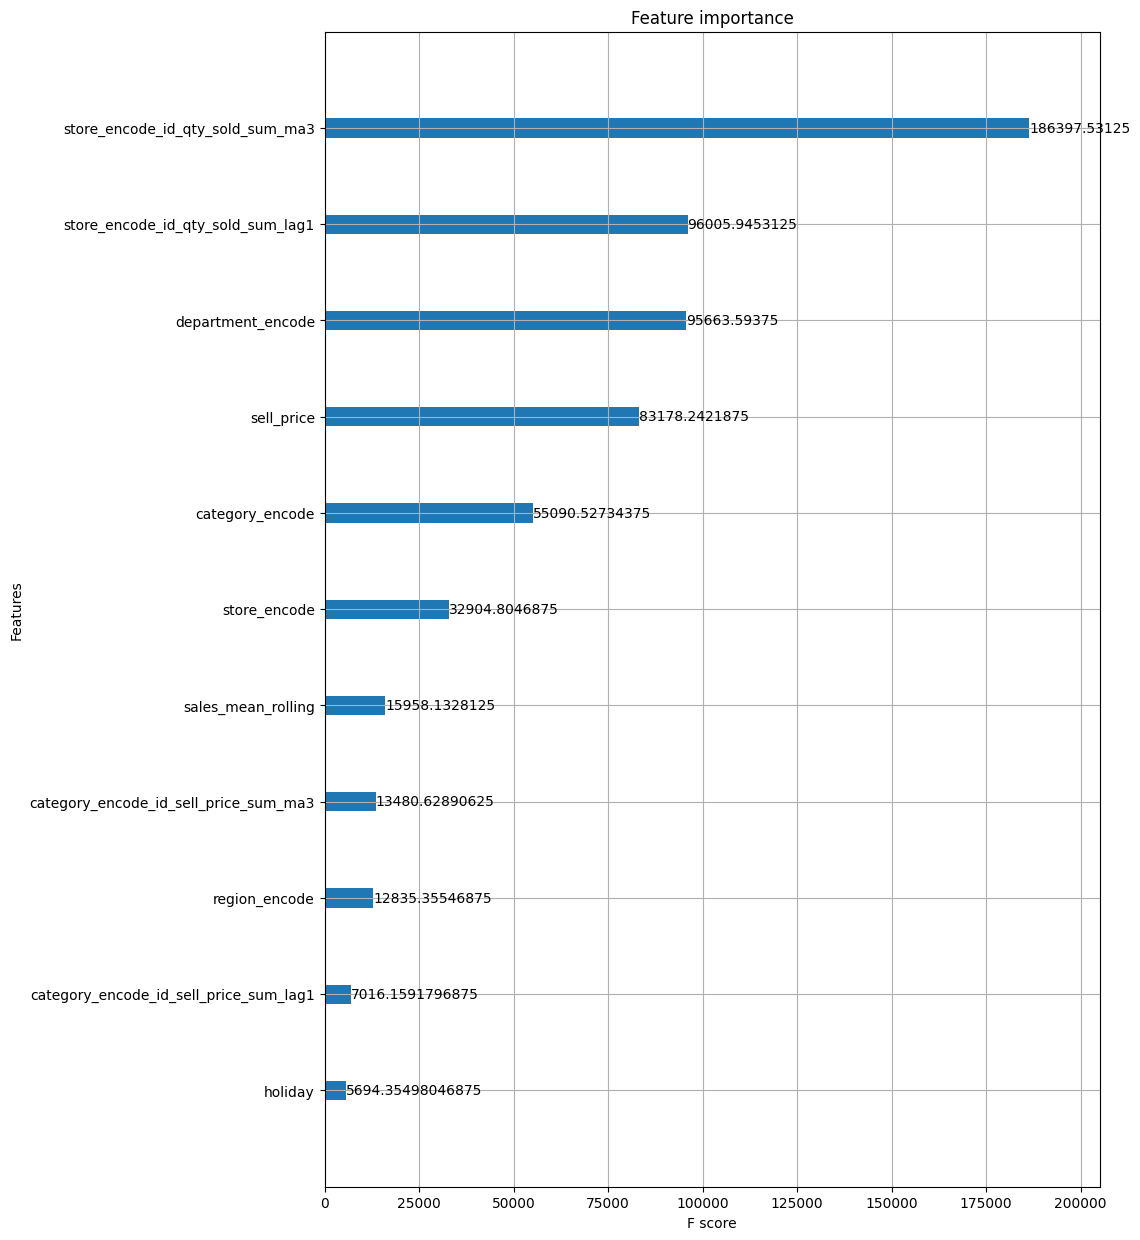

In [70]:
fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax);

# Prediction

In [71]:
if "qty_sold" in X_test.columns:
    X_test.drop("qty_sold", axis = 1, inplace = True)

Y_test_predict = model.predict(X_test)
X_test["qty_sold"] = Y_test_predict

In [72]:
X_test.reset_index(inplace = True)

In [73]:
X_test

,id,holiday,sell_price,store_encode,department_encode,category_encode,region_encode,store_encode_id_qty_sold_sum_lag1,store_encode_id_qty_sold_sum_ma3,category_encode_id_sell_price_sum_lag1,category_encode_id_sell_price_sum_ma3,sales_mean_rolling,qty_sold
0,ACCESORIES_1_001_NYC_1,0,11.1454,4,4,3,1,NaN,NaN,NaN,NaN,0.5,0.593551
1,ACCESORIES_1_002_NYC_1,0,5.2801,4,4,3,1,NaN,NaN,NaN,NaN,1.5,0.376263
2,ACCESORIES_1_003_NYC_1,0,3.9501,4,4,3,1,NaN,NaN,NaN,NaN,1.5,0.680719
3,ACCESORIES_1_004_NYC_1,0,6.1712,4,4,3,1,NaN,NaN,NaN,NaN,0.0,0.887478
4,ACCESORIES_1_005_NYC_1,0,3.8304,4,4,3,1,NaN,NaN,NaN,NaN,0.5,0.504551
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,SUPERMARKET_3_823_PHI_3,0,3.5760,10,1,1,3,NaN,NaN,NaN,NaN,1.0,1.222175
30486,SUPERMARKET_3_824_PHI_3,0,2.9760,10,1,1,3,NaN,NaN,NaN,NaN,1.5,1.209619
30487,SUPERMARKET_3_825_PHI_3,0,4.7760,10,1,1,3,NaN,NaN,NaN,NaN,0.5,1.117439
30488,SUPERMARKET_3_826_PHI_3,0,1.5360,10,1,1,3,NaN,NaN,NaN,NaN,0.0,4.817933


In [74]:
Y_train_predict = model.predict(X_train)
Y_valida_predict = model.predict(X_valida)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

In [75]:
print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

Train RMSE: 3_32
Validation RMSE: 2_325


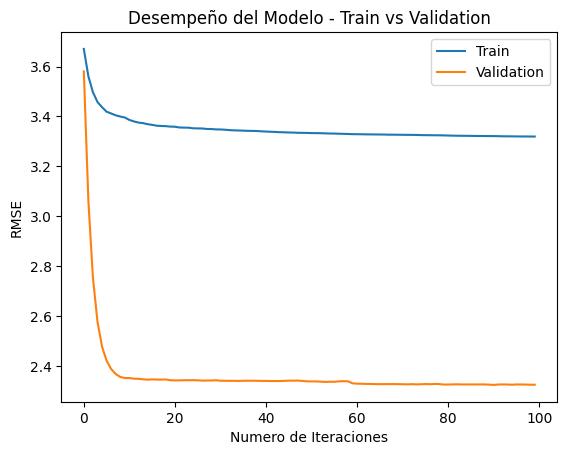

In [76]:
# Obtener métricas
results = model.evals_result()
# Gráfica de métricas
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# Métricas de entrenamiento
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
# Métricas de validação
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation')
plt.legend()
plt.xlabel('Numero de Iteraciones')
plt.ylabel('RMSE')
plt.title('Desempeño del Modelo - Train vs Validation')
plt.show()

In [78]:
# Subimos a Kaggle un fichero con este formato:
X_test[['id','qty_sold']]

,id,qty_sold
0,ACCESORIES_1_001_NYC_1,0.593551
1,ACCESORIES_1_002_NYC_1,0.376263
2,ACCESORIES_1_003_NYC_1,0.680719
3,ACCESORIES_1_004_NYC_1,0.887478
4,ACCESORIES_1_005_NYC_1,0.504551
...,...,...
30485,SUPERMARKET_3_823_PHI_3,1.222175
30486,SUPERMARKET_3_824_PHI_3,1.209619
30487,SUPERMARKET_3_825_PHI_3,1.117439
30488,SUPERMARKET_3_826_PHI_3,4.817933
